Line Detection

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the image
image_path = './assets/warped_image.png'
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detector
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Use Hough Line Transform to detect lines
lines = cv2.HoughLines(edges, 1, np.pi / 180, 140)

print(lines)


[[[555.          1.134464 ]]

 [[243.          1.6406095]]

 [[305.          1.6406095]]

 [[309.          1.6406095]]

 [[344.          1.2566371]]

 [[569.          1.134464 ]]

 [[254.          1.6231562]]

 [[257.          1.6231562]]

 [[567.          1.1170107]]

 [[260.          1.6231562]]

 [[337.          1.2566371]]

 [[570.          1.1170107]]]


In [3]:

# Create a copy of the original image to draw lines
line_image = np.copy(image)
# line_image = np.zeros_like(image)

# Draw lines on the image in red color
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red color

# # Display the original image, edges, and the image with lines
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 3, 1)
# plt.title('Original Image')
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# plt.subplot(1, 3, 2)
# plt.title('Edges')
# plt.imshow(edges, cmap='gray')

# plt.subplot(1, 3, 3)
# plt.title('Lines Detected')
# plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))

# plt.show()


Removal of noise lines

In [4]:
# Parameters for line merging
rho_threshold = 15
theta_threshold = np.pi / 90

# Function to merge lines
def merge_lines(lines, rho_threshold, theta_threshold):
    merged_lines = []
    for line in lines:
        rho, theta = line[0]
        merged = False
        for merged_line in merged_lines:
            rho_m, theta_m = merged_line
            if abs(rho - rho_m) < rho_threshold and abs(theta - theta_m) < theta_threshold:
                merged_lines.remove(merged_line)
                merged_lines.append(((rho + rho_m) / 2, (theta + theta_m) / 2))
                merged = True
                break
        if not merged:
            merged_lines.append((rho, theta))
    return merged_lines

# Merge lines
merged_lines = merge_lines(lines, rho_threshold, theta_threshold)

# # Create a copy of the original image to draw lines
line_image = np.copy(image)

# Draw merged lines on the image in red color
if merged_lines is not None:
    for rho, theta in merged_lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red color

# # Display the original image, edges, and the image with lines
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 3, 1)
# plt.title('Original Image')
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# plt.subplot(1, 3, 2)
# plt.title('Edges')
# plt.imshow(edges, cmap='gray')

# plt.subplot(1, 3, 3)
# plt.title('Lines Detected')
# plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
# plt.imsave('./assets/lines_detected.png', cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))

# plt.show()

In [5]:
# Function to find the intersection point of two lines
def intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    if np.linalg.det(A) != 0:  # Check if the determinant is non-zero (lines are not parallel)
        x0, y0 = np.linalg.solve(A, b)
        return int(np.round(x0)), int(np.round(y0))
    else:
        return None
        
# # Find intersections
# intersections = []
# for i in range(len(merged_lines)):
#     for j in range(i + 1, len(merged_lines)):
#         intersect = intersection(merged_lines[i], merged_lines[j])
#         if intersect:
#             intersections.append(intersect)

# # Draw intersections on the image in blue color
# for point in intersections:
#     cv2.circle(line_image, point, 5, (255, 0, 0), -1)  # Blue color

# # Display the original image, edges, and the image with lines and intersections
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 4, 1)
# plt.title('Original Image')
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# plt.subplot(1, 4, 2)
# plt.title('Edges')
# plt.imshow(edges, cmap='gray')

# plt.subplot(1, 4, 3)
# plt.title('Lines Detected')
# plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))

# plt.subplot(1, 4, 4)
# plt.title('Intersections')
# plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))

# plt.show()

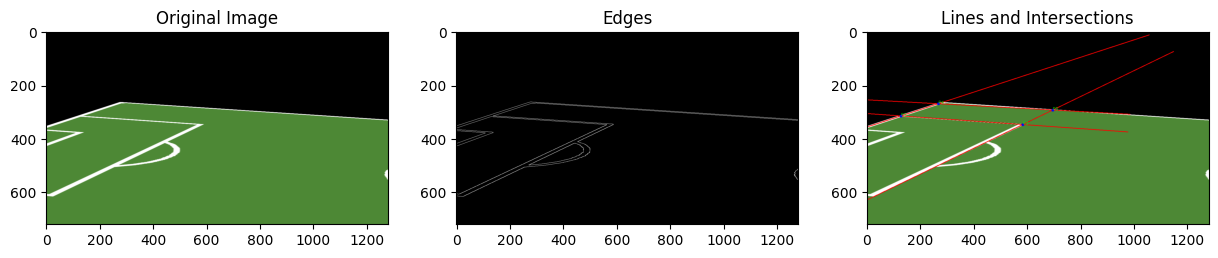

Intersection Points: [(-3326, 75), (127, 317), (583, 349), (267, 271), (695, 295), (1726, -203)]


In [6]:
# Function to calculate intersection point of two lines given in polar coordinates
def get_intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]])
    b = np.array([rho1, rho2])
    x, y = np.linalg.solve(A, b)
    return (int(np.round(x)), int(np.round(y)))

# Find intersection points
intersection_points = []
for i in range(len(merged_lines)):
    for j in range(i + 1, len(merged_lines)):
        intersection = get_intersection(merged_lines[i], merged_lines[j])
        intersection_points.append(intersection)

# Create a copy of the original image to draw lines and points
line_image = np.copy(image)

# Draw merged lines on the image in red color and label them
for idx, (rho, theta) in enumerate(merged_lines):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red color
    # Label the line
    cv2.putText(line_image, f'L{idx+1}', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

# Draw intersection points on the image and label them
for idx, (x, y) in enumerate(intersection_points):
    cv2.circle(line_image, (x, y), 5, (255, 0, 0), -1)  # Blue color
    # Label the intersection point
    cv2.putText(line_image, f'P{idx+1}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

# Display the original image, edges, and the image with lines and points
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title('Edges')
plt.imshow(edges, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Lines and Intersections')
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.imsave('./assets/lines_intersections.png', cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))

plt.show()

# Print intersection points
print("Intersection Points:", intersection_points)

In [7]:
print(intersection_points)

[(-3326, 75), (127, 317), (583, 349), (267, 271), (695, 295), (1726, -203)]
